# Import

In [1]:
# torch package
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# dataset packagea
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# metrcis
from sklearn.metrics import accuracy_score, classification_report

# ETC
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class SimpleVGG16(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        [(H_in + 2P - K)/S] + 1
        '''

        # (3, 224, 224) -> (64, 112, 112)
        self.layer1 = nn.Sequential(\
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) )
        
        # (64, 112, 112) -> (128, 56, 56)
        self.layer2 = nn.Sequential(\
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) )
        
        # (128, 56, 56) -> (256, 28, 28)
        self.layer3 = nn.Sequential(\
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) )

        # (256, 28, 28) -> (512, 14, 14)
        self.layer4 = nn.Sequential(\
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) )
        
        # (512, 14, 14) -> (512, 7, 7)
        self.layer5 = nn.Sequential(\
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) )


        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10) # 원래는 1000 임. 데이터셋을 CIFAR10 으로 해서 마지막 출력 노드가 10인것.

        self.relu = nn.ReLU()
            
        self.dropout = nn.Dropout(p=0.5)
        


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        vgg16_output = self.fc3(out)

        return vgg16_output

# Train

In [3]:
def train(model, config, train, valid, optimizer=False, loss=False):
    train_loss_history = []
    valid_loss_history = []
    
    optimizer = optimizer if optimizer else optim.Adam(model.parameters(), lr=config.learning_rate)
    loss_function = loss if loss else nn.CrossEntropyLoss()


    for i in range(config.epochs):

        train_loss_ = 0
        model.train()
        with torch.enable_grad():
            for feature, label in train:
                feature, label = feature.to(config.device), label.to(config.device)
                optimizer.zero_grad()               
                # outputs = model(feature.view(config.batch_size, 1, 28, 28))
                outputs = model(feature)
                loss = loss_function(outputs, label)
                # loss.requires_grad_(True)
                loss.backward()
                optimizer.step()

                train_loss_ += loss.item()

        train_loss_ /= config.batch_size
        train_loss_history.append(train_loss_)


        valid_loss_ = 0
        model.eval()
        with torch.no_grad():
            for feature, label in valid:
                feature, label = feature.to(config.device), label.to(config.device)
                # outputs = model(feature.view(config.batch_size, 1, 28, 28))
                outputs = model(feature)
                loss = loss_function(outputs, label)
                
                valid_loss_ += loss.item()

        valid_loss_ /= config.batch_size
        valid_loss_history.append(valid_loss_)

        if (i+1)%int((config.epochs)*0.1)==0:
            print(f"epoch : {i+1} Loss(train) : {train_loss_history[-1]:.3f}  Loss(valid) : {valid_loss_history[-1]:.3f}")


    
    plt.plot(train_loss_history, label='Training loss')
    plt.plot(valid_loss_history, label='Validation loss')
    plt.legend()
    plt.show()
    print("="*40)
    print("Training loss: ", train_loss_history[-1])
    print("Validation loss: ", valid_loss_history[-1])
    print("="*40)

# Predict

In [4]:
def predict_evaluate(model, config, test):
    model.eval()
    output_list = []
    acc = []

    y_pred = torch.Tensor()
    y_test = torch.Tensor()
    with torch.no_grad():
        for feature, label in test:
            feature, label = feature.to(config.device), label.to(config.device)
            # outputs = model(feature.view(config.batch_size, 1, 28, 28))
            outputs = model(feature)
            output_list.append(outputs)
            outputs = outputs.cpu()
            _, outputs = torch.max(outputs, 1)
            
            label = label.cpu()

            acc.append(accuracy_score(label, outputs))
            y_pred = torch.cat((y_pred, outputs), dim=0)
            y_test = torch.cat((y_test, label), dim=0)

    
    print(f"Accuracy: {(sum(acc)/len(acc)):.3f}")

    return y_test, y_pred

# Hyperparameter config

In [5]:
class config():
    def __init__(self, device, learning_rate=0.001, epochs=100, batch_size = 128):
        self.learning_rate = learning_rate

        self.batch_size = batch_size
        self.epochs = epochs

        self.device = device

# Dataset

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True) # 48000
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True) # 12000 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)  # 10000

Files already downloaded and verified
Files already downloaded and verified


# Model

In [7]:
train_config = config(device = device,
                    learning_rate = 0.05,
                    epochs = 100,
                    batch_size = 64)

In [8]:
vgg16 = SimpleVGG16().to(device)

epoch : 10 Loss(train) : 2448203.793  Loss(valid) : 368841.556
epoch : 20 Loss(train) : 694014.080  Loss(valid) : 380892.833
epoch : 30 Loss(train) : 609278.376  Loss(valid) : 114621.688
epoch : 40 Loss(train) : 858833.044  Loss(valid) : 53038.183
epoch : 50 Loss(train) : 562521.049  Loss(valid) : 51516.000
epoch : 60 Loss(train) : 333018.745  Loss(valid) : 40883.390
epoch : 70 Loss(train) : 140791.987  Loss(valid) : 12733.242
epoch : 80 Loss(train) : 81103.556  Loss(valid) : 14230.146
epoch : 90 Loss(train) : 49768.721  Loss(valid) : 7498.263
epoch : 100 Loss(train) : 15194.394  Loss(valid) : 1855.981


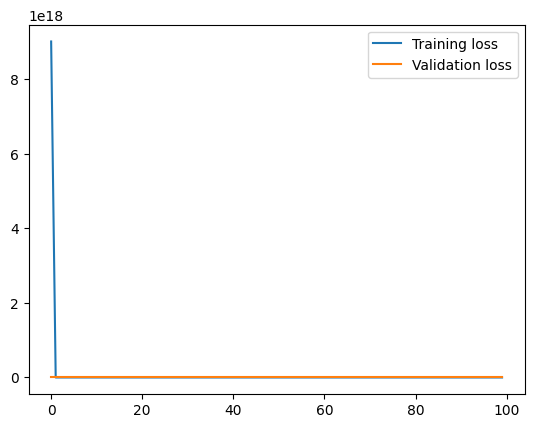

Training loss:  15194.393538951874
Validation loss:  1855.9807949066162


In [9]:
train(vgg16, train_config, train_loader, valid_loader)

# Evaluation

In [10]:
y_test, y_pred = predict_evaluate(vgg16, train_config, test_loader)

Accuracy: 0.100


In [11]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.10      1.00      0.18      1000
         1.0       0.00      0.00      0.00      1000
         2.0       0.00      0.00      0.00      1000
         3.0       0.00      0.00      0.00      1000
         4.0       0.00      0.00      0.00      1000
         5.0       0.00      0.00      0.00      1000
         6.0       0.00      0.00      0.00      1000
         7.0       0.00      0.00      0.00      1000
         8.0       0.00      0.00      0.00      1000
         9.0       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



c:\Users\Xenrose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Xenrose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Xenrose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av